# Scenario Generator

The purpose of this notebook is to generate scenarios in a given domain.
For now, it assumes:
- There are two land uses, "urban" and "forest"
- "Urban" land use is contiguous (one patch), and fits entirely within the domain
- "Urban land use total area is 30 cells
- The total domain dimensions are 10 (dy) x 12 (dx) cells (`mat = np.ones((12,10))`)

In [9]:
import numpy as np
import itertools
from pylab import *
from subsurface import createpfb3, createpfb2
import subprocess

%matplotlib inline

In [2]:
def find_factors(value):
    '''
    A function to get all factor pairs of a given integer
    Outputs a list of tuples
    '''
    factors = []
    for i in range(1, int(value**0.5)+1):
        if value % i == 0:
            factors.append((float(i), value / i))
    return factors

def prune_f_pairs(f_pairs, dom_dx, dom_dy):
    '''
    Removes factor pairs whose dimensions exceed the domains
    (will not fit into domain as one "patch")
    '''
    new_fp = []
    for f in f_pairs:
        if max(f) > max(dom_dx,dom_dy): # one pair of the factor exceeds the domain, need to check if it exceeds the other
            if max(f) <= min(dom_dx,dom_dy): # if it does, then don't keep this pair
                new_fp.append(f)
        else:
            new_fp.append(f)
        
    return(new_fp)

def make_combinations(list1, list2):
    '''
    make combinations given two lists
    '''
    combs = []
    for element in itertools.product(list1, list2):
            combs.append(element)
    return(combs)
    
def get_upper_left_index(dom_x, dom_y, f_pairs):
    '''
    A list of feasible upper left indexes, given dims of domain
    and dims of patch
    '''

    results = []
    
    for f in f_pairs:
    
        # can patch's longside be oriented on x?
        if max(f) <= dom_x:
            patch_dims = (max(f), min(f))
            x_ind_list = list(range(0, dom_x - int(max(f)) + 1) )
            # then the short side (min(f)), has to be oriented on y:
            y_ind_list = list(range(0, dom_y - int(min(f)) + 1) )

            upper_left_indices = make_combinations(x_ind_list, y_ind_list)
            
            results.append({'patch_xdim': patch_dims[0],
                        'patch_ydim':  patch_dims[1],
                        'upperleftind':upper_left_indices })
        else:
            print("cannot be oriented with long side on x")
            upper_left_indices = []

        # can patch's longside be oriented on y?
        if max(f) <= dom_y:
            patch_dims = (min(f), max(f))
            x_ind_list = list(range(0, dom_x - int(min(f)) + 1) )
            y_ind_list = list(range(0, dom_y - int(max(f)) + 1) )  

            upper_left_indices = make_combinations(x_ind_list, y_ind_list)
            
            results.append({'patch_xdim': patch_dims[0],
                        'patch_ydim':  patch_dims[1],
                        'upperleftind':upper_left_indices })
        else:
            print("cannot be oriented with long side on y")
            upper_left_indices = []

    return(results)


In [3]:
fp = find_factors(30)
fp = prune_f_pairs(fp,12,10)
#fp = prune_f_pairs(fp, dx, dy)
print(fp)
res_dict = get_upper_left_index(12,10,fp)

[(3.0, 10.0), (5.0, 6.0)]


# For Loop to generate all 

In [4]:
nrows = 15
ncols = 8
row = list(itertools.chain.from_iterable(itertools.repeat(x, ncols) for x in range(0,nrows)))
col = list(range(0,ncols)) *nrows
row[0],col[0]

(0, 0)

TypeError: Image data cannot be converted to float

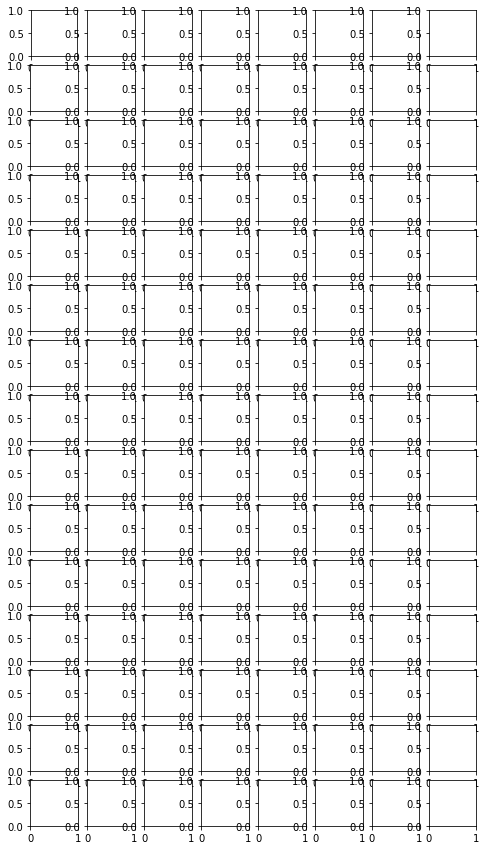

In [5]:
f, axarr = plt.subplots(nrows, ncols, figsize=(8,15))
axarr[row[0],col[0]].imshow(mat, interpolation='nearest')
axarr[row[0],col[0]].set_title("scen")
axarr[row[0],col[0]].axis('off')

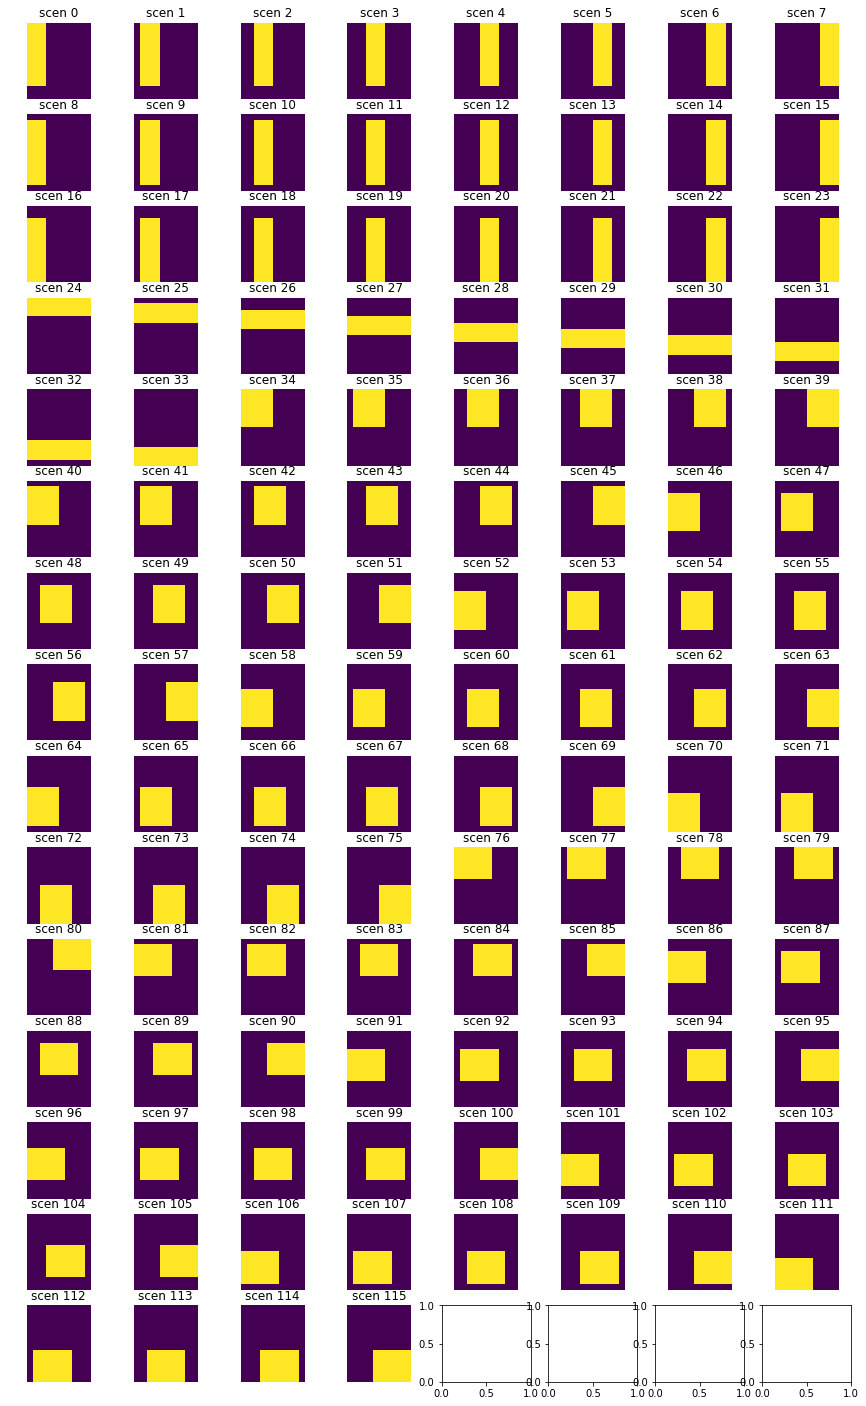

In [6]:
mat_res = []
    
# for each patch in res_dict, create the domain matrix:
nrows = 15
ncols = 8
row = list(itertools.chain.from_iterable(itertools.repeat(x, ncols) for x in range(0,nrows)))
col = list(range(0,ncols)) *nrows

f, axarr = plt.subplots(nrows, ncols, figsize=(15,25))

ii = 0

for patch in res_dict:
    #print(mat) 
    
    cur_patch_xdim = patch['patch_xdim']
    cur_patch_ydim = patch['patch_ydim']
    
    for unique_corner in patch['upperleftind']:
        mat = np.ones((12,10))
        
        r = row[ii]
        c = col[ii]
        
        x_start = int(unique_corner[0])
        x_end = int(x_start + cur_patch_xdim )
        y_start = int(unique_corner[1])
        y_end = int(y_start + cur_patch_ydim )
        
        #print("x start: %s \ny_start: %s" %(x_start, y_start))      
        
        mat[x_start : x_end , y_start:y_end] = 2
        
        axarr[r,c].imshow(mat, interpolation='nearest')
        axarr[r,c].set_title("scen %s" %ii)
        axarr[r,c].axis('off')
        
        ii=ii+1
        
        mat_res.append(mat)
    

In [38]:
#f.savefig('scenario_key_30_urb.png')

In [7]:
len(mat_res)

116

# For each scenario, create a directory, and subsurface input files

In [8]:
# first row is bottom of domain
# landco = 1 is "forest"
# landco = 2 is urban

landco_perm = np.array([[0.0002,0.0002],  # "bedrock" layer
                       [4.75,0.41],         # "saprolite"
                       [4.75,0.0000306]])        # topsoil

landco_mann = np.array([[2,0.00001]])

landco_indic = np.array([[1.0,1.0], # bottom layer
                       [2.0,2.0],
                       [3.0,4.0]]) #top layer 



In [29]:
scennames = ["scen%03d" %i for i in range(len(mat_res))]

for i, scen in enumerate(mat_res):
    scennam = scennames[i]
    
    # make a unique directory for this scenario
    #bashCommand = "mkdir %s" %scennam
    #process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    
    # Create the permeability pfb
    a = createpfb3(arrin = mat_res[i], dx = 100, dy = 100, dz = 1, nlc = 2, nx = 12, ny = 10, nz = 3,
                   lcin = landco_perm, 
                   arroutfnam='/home/tclim/Dropbox/projects/pf_simple/00preproc/01subsurf_scen/%s/perm_scen.pfb' %scennam)

    # Create the mannings pfb
    b = createpfb2(arrin = mat_res[i], dx = 100, dy = 100, dz = 1, nlc = 2, nx = 12, ny = 10,
                   lcin_flat = landco_mann, 
                   arroutfnam='/home/tclim/Dropbox/projects/pf_simple/00preproc/01subsurf_scen/%s/mann_scen.pfb' %scennam)

    # Create the indicator pfb (for use for porosity)
    c = createpfb3(arrin = mat_res[i], dx = 100, dy = 100, dz = 1, nlc = 2, nx = 12, ny = 10, nz = 3,
                   lcin = landco_indic, 
                   arroutfnam='/home/tclim/Dropbox/projects/pf_simple/00preproc/01subsurf_scen/%s/ind_scen.pfb' %scennam)